## Accessing Landsat 8 Collection 2 Level 2 data with the Planetary Computer STAC API

The [Landsat](https://landsat.gsfc.nasa.gov/) program has been imaging the Earth since 1972; it provides a comprehensive, continuous archive of the Earth's surface.

This dataset represents the global archive of Level-2 [Landsat 8](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-8) data from [Landsat Collection 2](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-collection-2).  Images are stored in [cloud-optimized GeoTIFF](https://www.cogeo.org/) format.

This notebook demonstrates the use of the Planetary Computer STAC API to query for Landsat 8 data.

### Get RGI polygons for W Canada and USA

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# load data and join bounds
df = gpd.read_file("data/02_rgi60_WesternCanadaUS.shp")
df = pd.concat([df, df.bounds], axis=1)

# print(df.crs)
# plt.figure(figsize=(10,10))
# df.plot(ax=plt.gca())

### Environment setup

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key.
The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) is pre-configured to use your API key.

In [2]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from dask_gateway import GatewayCluster

# Set the environment variable PC_SDK_SUBSCRIPTION_KEY, or set it here.
# The Hub sets PC_SDK_SUBSCRIPTION_KEY automatically.
# pc.settings.set_subscription_key(<YOUR API Key>)

### Create a Dask cluster

We're going to process a large amount of data. To cut down on the execution time, we'll use a Dask cluster to do the computation in parallel, adaptively scaling to add and remove workers as needed. See [Scale With Dask](../quickstarts/scale-with-dask.ipynb) for more on using Dask.

In [3]:
cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.

client = cluster.get_client()

cluster.adapt(minimum=4, maximum=24)
print(cluster.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.95abdded9d5b4bd99b4926424619250e/status


### Convert polygons to AOIs

In [4]:
# Let's start with large polygons
df['area'] = df.area
df = df.sort_values('area', ascending=False).reset_index(drop=True)

/tmp/ipykernel_553/1720519345.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df['area'] = df.area


In [5]:
def poly2aoi(poly):
    aoi = {
    "type": "Polygon",
    "coordinates": [list(poly.exterior.coords)],
}
    return aoi

### STAC search

In [6]:
time_of_interest = "2010-01-01/2020-12-31"
poly = df.geometry.iloc[0]
area_of_interest = poly2aoi(poly)

In [7]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest,
    datetime=time_of_interest,
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 25}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 126 Items


In [8]:
%%time
signed_items = []
for item in items:
    item.clear_links()
    signed_items.append(pc.sign(item).to_dict())

CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 525 ms


In [52]:
bands_sr = [f"SR_B{i}" for i in range(1,8)]

da_sr = (
    stackstac.stack(
        signed_items,
        epsg=32610,
        assets=bands_sr,
#         assets=["SR_B4", "SR_B3", "SR_B2"],
        chunksize=4096,
        resolution=30,
        bounds_latlon=poly.bounds
    )
#     .where(lambda x: x != -32768, other=np.nan)  
    # sentinel-2 uses 0 as nodata, l8 -32768
#     .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)
da_sr

<xarray.DataArray 'stackstac-d5312f80f741f39dc13ce32b720e2064' (time: 85, band: 7, y: 1262, x: 1055)>
dask.array<fetch_raster_window, shape=(85, 7, 1262, 1055), dtype=float64, chunksize=(1, 1, 1262, 1055), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2013-05-05T19:14:48.76...
    id                           (time) <U31 'LC08_L2SP_049024_20130505_02_T1...
  * band                         (band) <U5 'SR_B1' 'SR_B2' ... 'SR_B6' 'SR_B7'
  * x                            (x) float64 2.789e+05 2.789e+05 ... 3.105e+05
  * y                            (y) float64 5.727e+06 5.727e+06 ... 5.689e+06
    landsat:wrs_type             <U1 '2'
    ...                           ...
    title                        (band) <U33 'Coastal/Aerosol Band (B1)' ... ...
    gsd                          float64 30.0
    common_name                  (band) <U7 'coastal' 'blue' ... 'swir22'
    center_wavelength            (band) float64 0.44 0.48 0.56 0.65 0.86 1.6 2.2
    full_width_half_max          (band) float64 0.02 0.06 0.06 ... 0.03 0.08 0.2
    epsg                         int64 32610
Attributes:
    spec:        RasterSpec(epsg=32610, bounds=(278880, 5689230, 310530, 5727...
    crs:         epsg:32610
    transform:   | 30.00, 0.00, 278880.00|\n| 0.00,-30.00, 5727090.00|\n| 0.0...
    resolution:  30

In [53]:
da_sr = da_sr.persist()

### Mask by glacier polygon

In [11]:
import rasterio as rio

In [42]:
from pyproj import Transformer
from shapely.geometry import Polygon
from shapely.ops import transform
project = Transformer.from_crs("epsg:4326", "epsg:32610", always_xy=True).transform
poly_imgcrs = transform(project, poly)

# xs, ys = transformer.transform(*poly.exterior.coords.xy)
# poly_imgcrs = Polygon(zip(xs, ys))

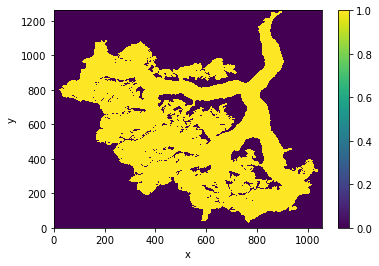

In [46]:
mask_glacier = rio.features.geometry_mask([poly_imgcrs],
                                      out_shape=(len(da_sr.y), len(da_sr.x)),
                                      transform=da_sr.transform,
                                      invert=True)

mask_glacier = xr.DataArray(mask_glacier , dims=("y", "x"))
# mask_glacier.plot()

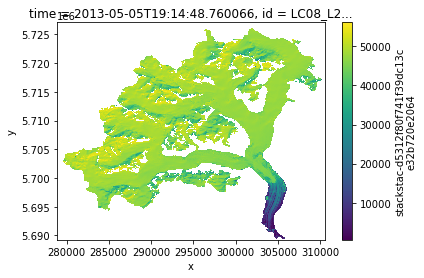

In [54]:
da_sr.isel(time=0, band=0).where(mask_glacier==True).plot()

### Compare on glacier to off glacier time-series

In [58]:
ts_on = da_sr.where(mask_glacier==True).median(dim=("x","y"))
ts_off = da_sr.where(mask_glacier==False).median(dim=("x","y"))

/srv/conda/envs/notebook/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


CPU times: user 1min 33s, sys: 30.7 s, total: 2min 4s
Wall time: 35.4 s


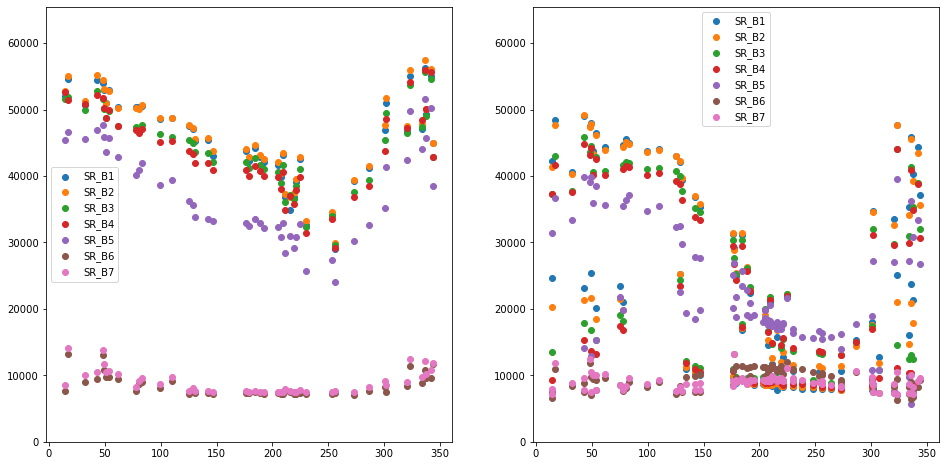

In [73]:
%%time
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,8)) 
ylim = (0, da_sr.max().values)

for band in da_sr.coords['band']:
    for ts, ax in zip([ts_on, ts_off], axes.flatten()):
        ax.scatter(ts.coords['time'].dt.dayofyear, ts.sel(band=band), label=str(band.values))
        ax.set_ylim(ylim)
        ax.legend()

### Pixel time series

In [ ]:
for band in da_sr.coords['band']:
    ts = da_sr.isel(x=600, y=600).sel(band=band)
    plt.scatter(da_sr.coords['time'].dt.dayofyear, ts)

### Median composite

Using normal xarray operations, we can [compute the median](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.median.html) over the time dimension. Under the assumption that clouds are transient, the composite shouldn't contain (many) clouds, since they shouldn't be the median pixel value at that point over many images.

This will be computed in parallel on the cluster (make sure to open the Dask Dashboard using the link printed out above).

In [156]:
median = data.median(dim="time").compute()

To visualize the data, we'll use xarray-spatial's `true_color` method to convert to red/green/blue values.

In [157]:
image = ms.true_color(*median)  # expects red, green, blue DataArrays

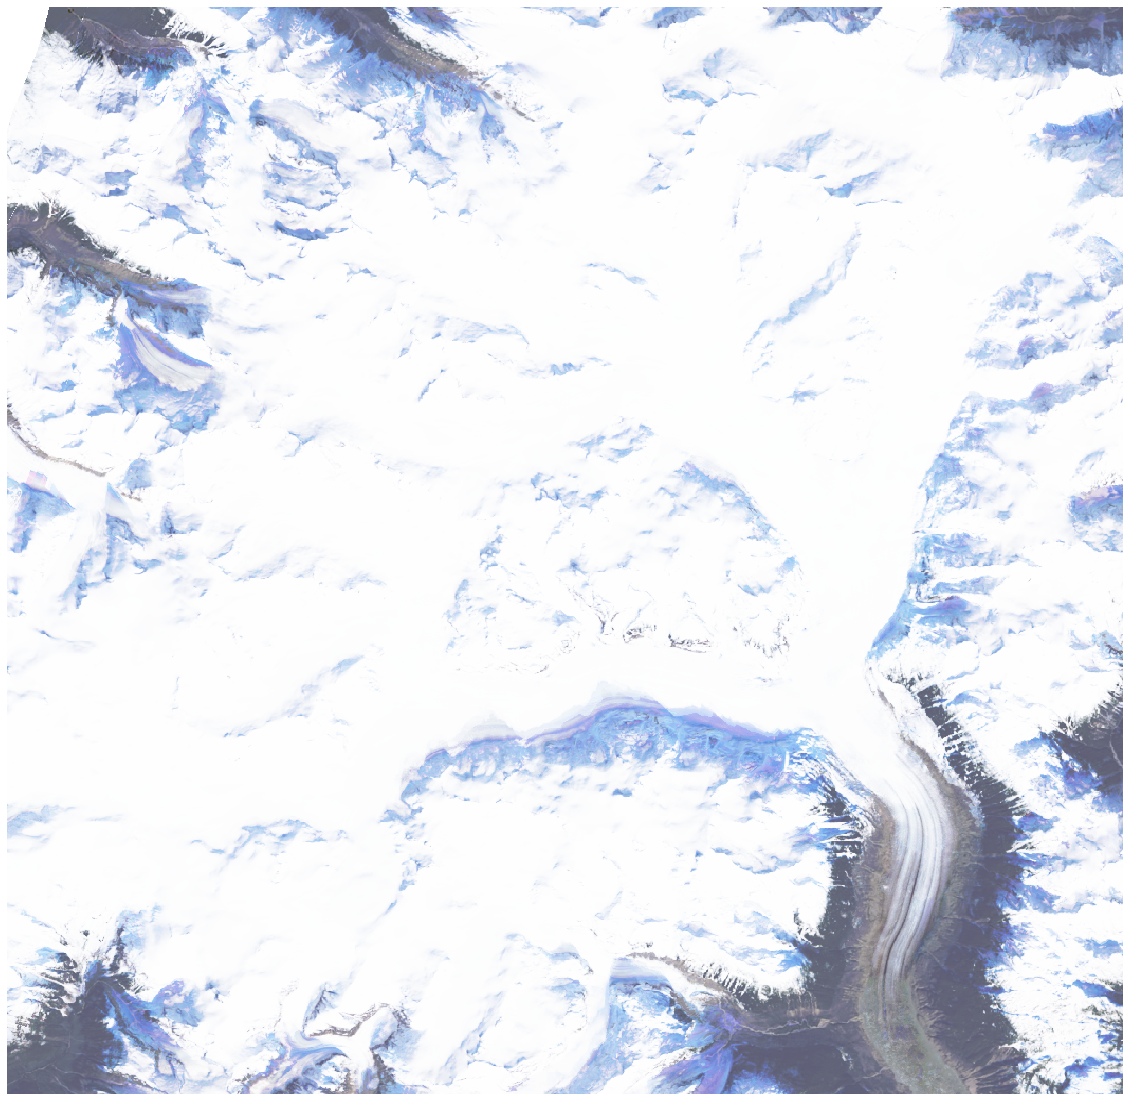

In [158]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 20))

ax.set_axis_off()
image.plot.imshow(ax=ax);

### Monthly composite

Now suppose we don't want to combine images from different parts of the year (for example, we might not want to combine images from January that often include snow with images from July). Again using standard xarray syntax, we can create set of per-month composites by grouping by month and then taking the median.

In [159]:
monthly = data.groupby("time.month").median().compute()

Let's convert each of those arrays to a true-color image and plot the results as a grid.

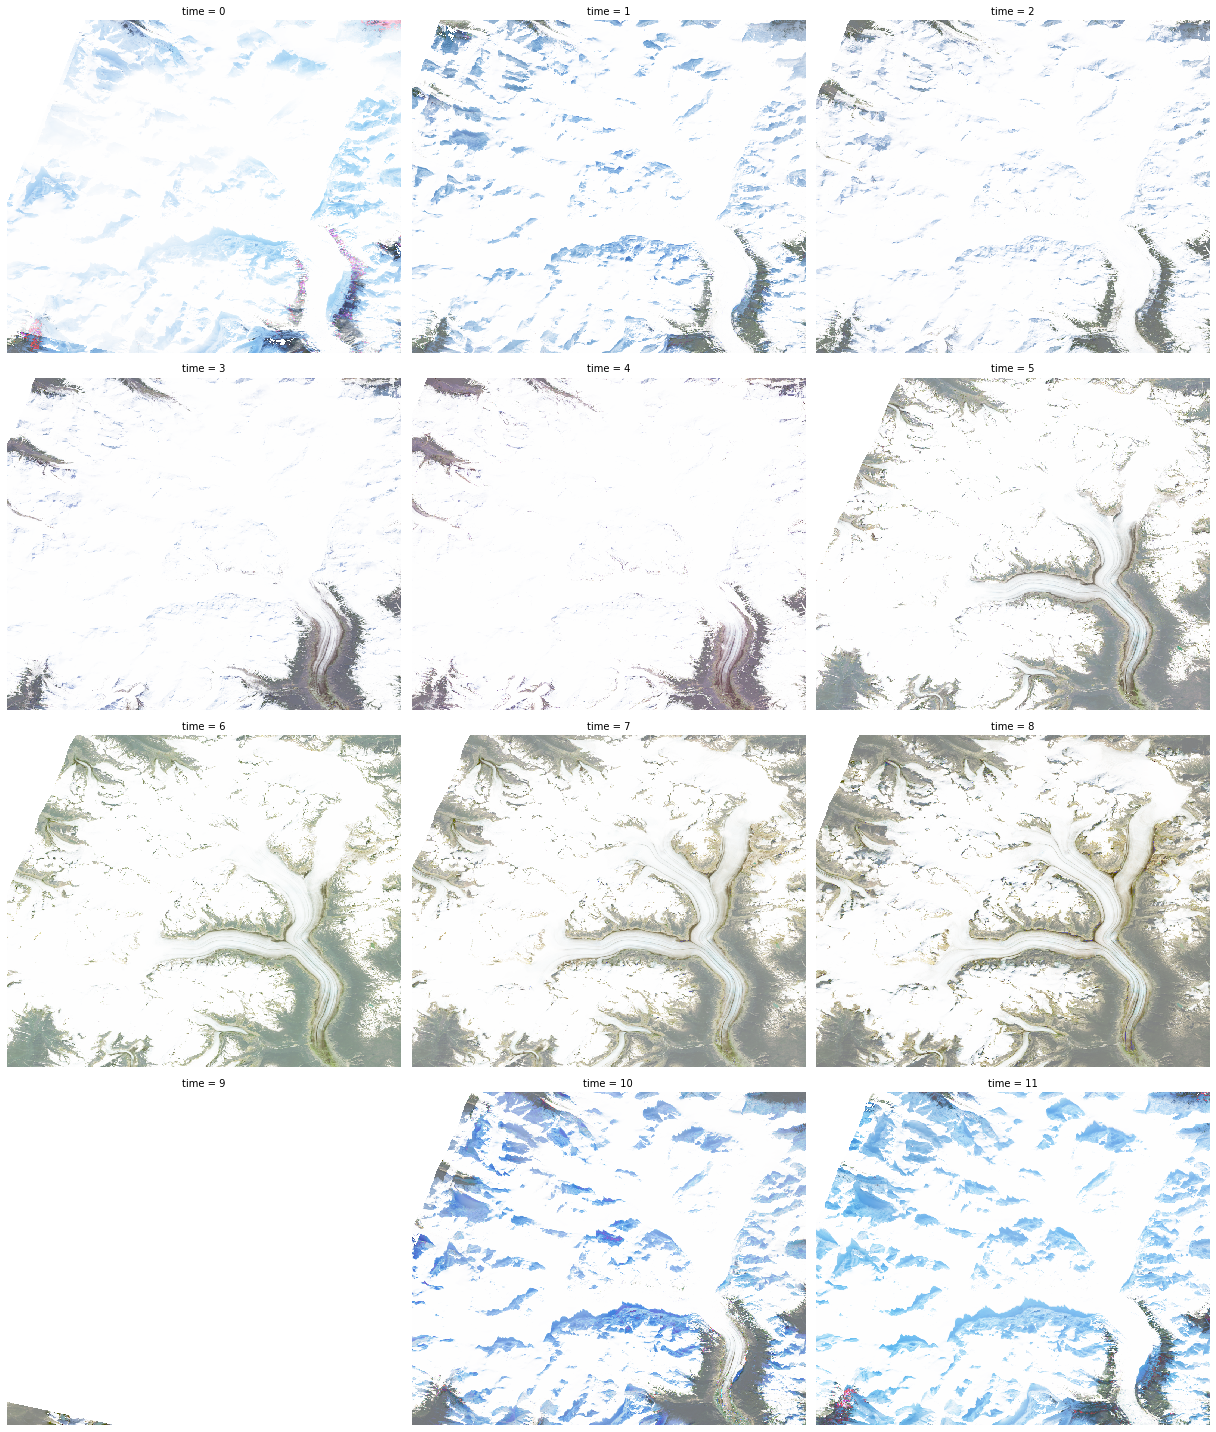

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:1131)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 1

In [160]:
images = [ms.true_color(*x) for x in monthly]
images = xr.concat(images, dim="time")

g = images.plot.imshow(x="x", y="y", rgb="band", col="time", col_wrap=3, figsize=(17, 20))
for ax in g.axes.flat:
    ax.set_axis_off()

plt.tight_layout()